In [1]:
import IPython.display as ipd
import sounddevice as sd
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
import numpy
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import os
import scipy.signal
import matplotlib.pyplot as plt

import seaborn as sns

from scipy import stats

import tensorflow as tf
from tensorflow import keras

from joblib import load, dump

2023-05-31 09:35:58.772172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 09:35:59.446738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-31 09:35:59.446830: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-31 09:36:01.687745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Chargement des fichiers audios

In [2]:
# Chargement des différents fichiers audio

aissa_audios = []
aissa_audios_paths = []

for file in os.listdir("./Aissa"):

    # Charger l'audio dans la liste aissa audios
    if file != "README.md":
        aissa_audios_paths.append("Aissa/"+file)
        audio_aissa, sr_aissa = librosa.load("Aissa/" + file)
        aissa_audios.append(audio_aissa)



marouan_audios = []
marouan_audios_paths = []

for file in os.listdir("./Marouan"):
    # Changer l'audio dans la liste marouan audios
    if file != "README.md":
        marouan_audios_paths.append("Marouan/"+file)
        audio_marouan, sr_marouan = librosa.load("Marouan/" + file)
        marouan_audios.append(audio_marouan)



autre_audios = []
autre_audios_paths = []

for file in os.listdir("./Autre"):
    # Changer l'audio dans la liste autre audios
    if file != "README.md":
        autre_audios_paths.append("Autre/"+file)
        audio_autre, sr_autre = librosa.load("Autre/" + file)
        autre_audios.append(audio_autre)
        


## Preprocessing

In [3]:
# Preprocessing the audios : bandpass filter + remove silences
def pretraitment(sound):
    sound_filtered = pass_band_filter(sound)
    sound_no_silence = remove_silence(sound_filtered)
    return sound_no_silence

def pretraitment_autre(sound):
    sound_filtered = pass_band_filter(sound)
    return sound_filtered

def remove_silence(signal):
    # extract non-silent intervals from the voice signal
    voice_intervals = librosa.effects.split(signal, frame_length=2048, top_db=35, hop_length=512)
    voice_no_silence = np.array([])
    slices = [signal[interval[0]:interval[1]] for interval in voice_intervals]
    voice_no_silence = np.concatenate(slices)
    return voice_no_silence

def pass_band_filter(sound, sr_sound=22050):
    # design a filter to remove the background noise using `scipy.signal.iirfilter`
    b, a = scipy.signal.iirfilter(1, [128, 2048], btype="bandpass", fs=sr_sound)

    # apply the filter using `scipy.signal.lfilter`
    y_sound_filt = scipy.signal.filtfilt(b, a, sound)
    return y_sound_filt
    

In [4]:
aissa_audios_preprocessed = [pretraitment(sound) for sound in aissa_audios]

marouan_audios_preprocessed = [pretraitment(sound) for sound in marouan_audios]

autre_audios_preprocessed = [sound for sound in autre_audios]


### Exemple de comparaison entre un signal brut et un signal prétraité

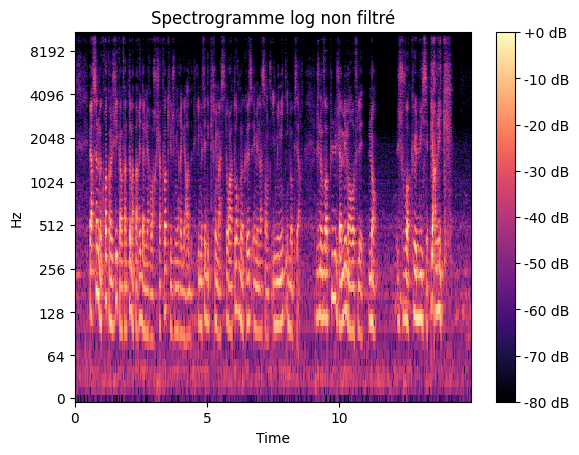

In [5]:
 # compute spectrogram for noisy voice signal
spec_voice = librosa.stft(aissa_audios[0])
spec_voice_db = librosa.amplitude_to_db(np.abs(spec_voice), ref=np.max)

# plot spectrogram for noisy voice signal
fig, ax = plt.subplots()
img = librosa.display.specshow(spec_voice_db, x_axis="time", y_axis="log", sr=22050)
_ = ax.set(title="Spectrogramme log non filtré")
_ = fig.colorbar(img, ax=ax, format="%+2.f dB")

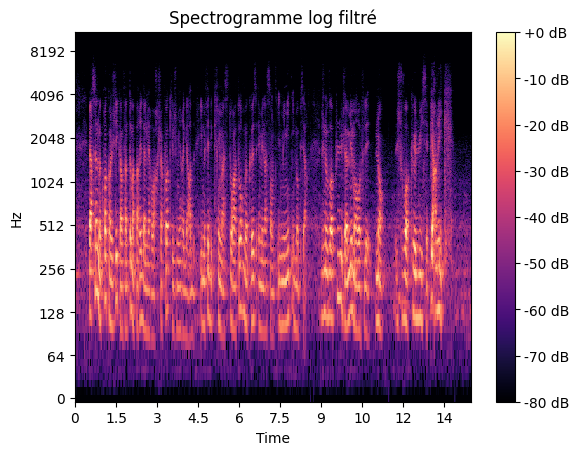

In [6]:
 # compute spectrogram for noisy voice signal
spec_voice = librosa.stft(aissa_audios_preprocessed[0])
spec_voice_db = librosa.amplitude_to_db(np.abs(spec_voice), ref=np.max)

# plot spectrogram for noisy voice signal
fig, ax = plt.subplots()
img = librosa.display.specshow(spec_voice_db, x_axis="time", y_axis="log", sr=22050)
_ = ax.set(title="Spectrogramme log filtré")
_ = fig.colorbar(img, ax=ax, format="%+2.f dB")

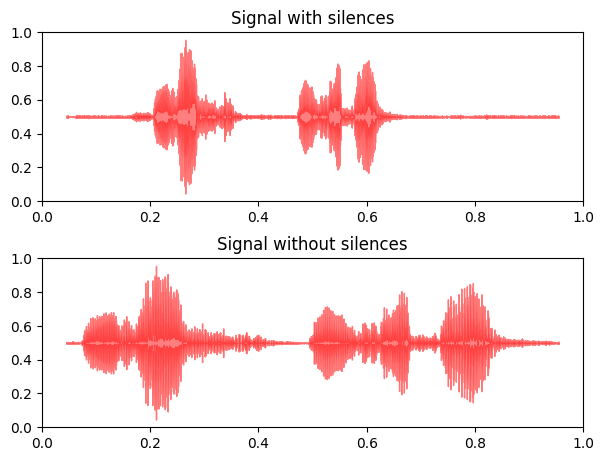

In [7]:
 # display waveform of voice signal with silences and without silence
fig, ax = plt.subplots(2,1)
fig.tight_layout(pad=2.0)

ax1 = fig.add_subplot(211)
ax1.axis('off')
ax1.set_title("Signal with silences")
_ = librosa.display.waveshow(marouan_audios[1], sr=22050, color='r', alpha=0.5)

ax2 = fig.add_subplot(212)
ax2.axis('off')
ax2.set_title("Signal without silences")
_ = librosa.display.waveshow(marouan_audios_preprocessed[1], sr=22050, color='r', alpha=0.5)

## Extraction des features

In [8]:
 # generate dataset from the audio signal, the samplerate and the label
def generate_dataset(audio, sr=22050):
    # generate Mel spectrogram
    spec = librosa.feature.melspectrogram(audio, sr=sr)
    
    
    # generate DataFrame from spectrogram (columns: frequencies, rows: analysis frames)
    X = pd.DataFrame(np.transpose(spec))
    return X

def generate_labels(df, label):
    y = pd.Series([label for row in range(df.shape[0])]) # pd.Series(label).repeat(X.shape[0])
    return y

In [9]:
df_list_aissa = [generate_dataset(audio) for audio in aissa_audios_preprocessed]
df_aissa = pd.concat(df_list_aissa)
y_aissa = generate_labels(df_aissa, "aissa")

df_list_marouan = [generate_dataset(audio) for audio in marouan_audios_preprocessed]
df_marouan = pd.concat(df_list_marouan)
y_marouan = generate_labels(df_marouan, "marouan")

df_list_autre = [generate_dataset(audio) for audio in autre_audios_preprocessed]
df_autre = pd.concat(df_list_autre)
y_autre = generate_labels(df_autre, "autre")


X = pd.concat([df_aissa, df_marouan, df_autre])
y = pd.concat([y_aissa, y_marouan, y_autre])

/tmp/ipykernel_28155/2777986350.py:4: FutureWarning: Pass y=[0.00226929 0.00241696 0.00253923 ... 0.00347073 0.00310642 0.00269124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)
/tmp/ipykernel_28155/2777986350.py:4: FutureWarning: Pass y=[ 0.00116072  0.00110432  0.0010661  ... -0.00109449 -0.00078019
 -0.00044169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)
/tmp/ipykernel_28155/2777986350.py:4: FutureWarning: Pass y=[-0.02734831 -0.01781069 -0.0097744  ... -0.00025109  0.00025858
  0.00073944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)
/tmp/ipykernel_28155/2777986350.py:4: FutureWarning: Pass y=[-5.79024448e-06 -5.27108061e-06 -4.75898207e-06 ...  6.94536314e-03
  7.1961

/tmp/ipykernel_28155/2777986350.py:4: FutureWarning: Pass y=[-5.79024448e-06 -5.27108061e-06 -4.75898207e-06 ...  6.94536314e-03
  7.19611824e-03  7.37114292e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)


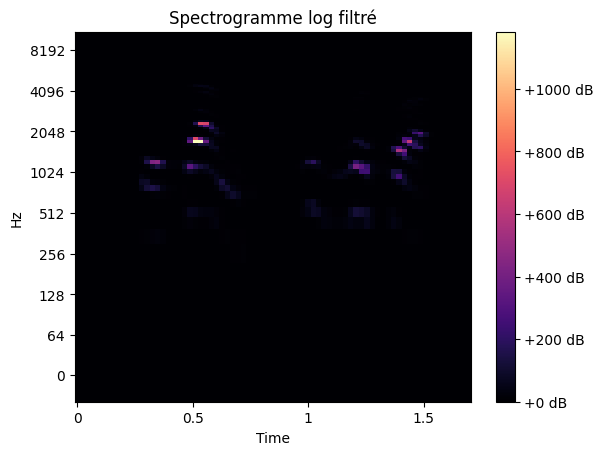

In [10]:
first_spec = generate_dataset(aissa_audios_preprocessed[3]) 
first_spec_scaled = first_spec / max(first_spec.max())*255

fig, ax = plt.subplots()
img = librosa.display.specshow(first_spec.transpose().to_numpy(), x_axis="time", y_axis="log", sr=22050)
_ = ax.set(title="Spectrogramme log filtré")
_ = fig.colorbar(img, ax=ax, format="%+2.f dB")


In [11]:
first_spec_marouan = generate_dataset(marouan_audios_preprocessed[0]) 
first_spec_aissa = generate_dataset(aissa_audios_preprocessed[0]) 
max(first_spec_aissa.max())

/tmp/ipykernel_28155/2777986350.py:4: FutureWarning: Pass y=[-0.00113923 -0.00161796 -0.00226832 ...  0.00324324  0.00268843
  0.00204008] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)
/tmp/ipykernel_28155/2777986350.py:4: FutureWarning: Pass y=[0.00226929 0.00241696 0.00253923 ... 0.00347073 0.00310642 0.00269124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)


319.62067969071705

## Entrainement et évaluation d'un modèle de ML

### Observation séparabilité des classes (PCA)

/home/marouan/.local/share/virtualenvs/speaker_recognition-0E-18EG4/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


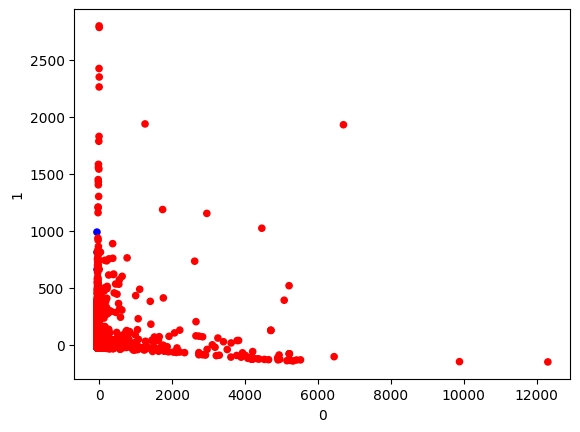

In [12]:
# observe the features using PCA decomposition over 2 dimensions
# classes clusters should be visually separable
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit(X).transform(X))
_ = X_pca.plot.scatter(x=0, y=1, c=y.apply(lambda x: "red" if x == "autre" else "blue"), colormap="plasma")

### Split des données / Pipeline / Entraînement / Prédiction

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Pipeline lr
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lr', LogisticRegression(random_state=42))
# ])


#Pipeline randomforest
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())#('rf', RandomForestClassifier(random_state=42)) #, n_estimators=100, max_depth=50, max_leaf_nodes=100))
])

# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#     max_depth=1, random_state=0))
# ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

/home/marouan/.local/share/virtualenvs/speaker_recognition-0E-18EG4/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[20, 50, 100], 'max_depth':[20, 50, 100], 'max_leaf_nodes': [20, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [20, 50, 100],
                         'max_leaf_nodes': [20, 50, 100],
                         'n_estimators': [20, 50, 100]})

In [15]:
clf.best_params_

{'max_depth': 50, 'max_leaf_nodes': 100, 'n_estimators': 100}

### Evaluation / Export du modèle

In [16]:
 # compute the accuracy score
accuracy_score(y_test, y_pred)

0.7086876155268023

In [17]:
f1_score(y_test, y_pred, pos_label=pipe.classes_[1], average="weighted")

/home/marouan/.local/share/virtualenvs/speaker_recognition-0E-18EG4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'autre') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.6793303869829267

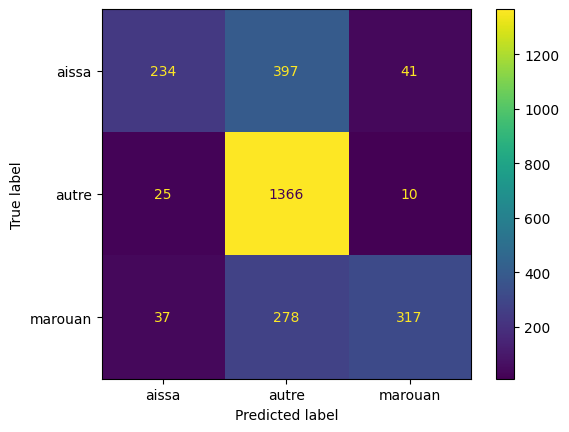

In [18]:
 # display the confusion matrix
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [20]:
y_pred = clf.best_estimator_.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       aissa       0.90      0.90      0.90       672
       autre       1.00      0.99      0.99      1401
     marouan       0.88      0.91      0.89       632

    accuracy                           0.95      2705
   macro avg       0.93      0.93      0.93      2705
weighted avg       0.95      0.95      0.95      2705



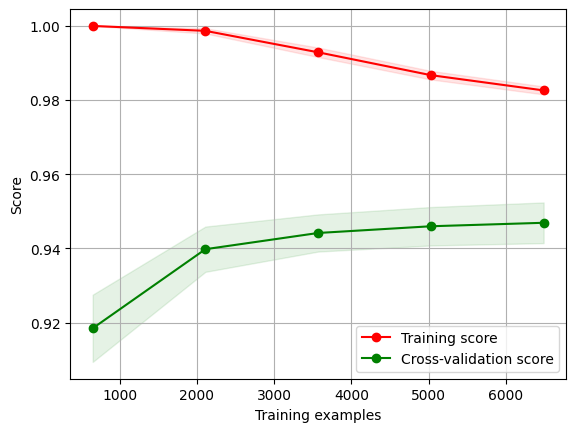

In [25]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve, ShuffleSplit

# LearningCurveDisplay.from_estimator(pipe["lr"], X_train, y_train, cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0), score_name="Accuracy")

train_sizes, train_scores, test_scores = learning_curve(
    clf.best_estimator_, X_train, y_train, cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0), scoring="accuracy")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

Export du modèle

In [ ]:
# dump(pipe, "rf_model.joblib")

['rf_model.joblib']

# CNN

In [555]:
# Chargement des différents fichiers audio
feature_list = []
label_list = []

aissa_audios = []
aissa_audios_paths = []

for file in os.listdir("./Aissa"):

    # Charger l'audio dans la liste aissa audios
    if file != "README.md":
        aissa_audios_paths.append("Aissa/"+file)
        audio_aissa, sr_aissa = librosa.load("Aissa/" + file, sr=None)
        audio = librosa.effects.time_stretch(y=audio_aissa, rate=len(audio_aissa)/sr_aissa)
        # Calculate features and get the label from the filename
        mels = librosa.feature.melspectrogram(y=audio, sr=sr_aissa, n_fft=2048, hop_length=512)
        mels_db = librosa.power_to_db(S=mels, ref=1.0)
        print(mels_db.shape)
        feature_list.append(mels_db.reshape((128, 94, 1)))
        label_list.append("aissa")
        aissa_audios.append(audio_aissa)



marouan_audios = []
marouan_audios_paths = []

for file in os.listdir("./Marouan"):
    # Changer l'audio dans la liste marouan audios
    if file != "README.md":
        marouan_audios_paths.append("Marouan/"+file)
        audio_marouan, sr_marouan = librosa.load("Marouan/" + file, sr=None)
        audio = librosa.effects.time_stretch(y=audio_marouan, rate=len(audio_marouan)/sr_marouan)
        # Calculate features and get the label from the filename
        mels = librosa.feature.melspectrogram(y=audio, sr=sr_marouan, n_fft=2048, hop_length=512)
        mels_db = librosa.power_to_db(S=mels, ref=1.0)
        print(mels_db.shape)
        feature_list.append(mels_db.reshape((128, 94, 1)))
        label_list.append("marouan")
        marouan_audios.append(audio_marouan)



autre_audios = []
autre_audios_paths = []

for file in os.listdir("./Autre"):
    # Changer l'audio dans la liste autre audios
    if file != "README.md":
        autre_audios_paths.append("Autre/"+file)
        audio_autre, sr_autre = librosa.load("Autre/" + file, sr=48000)
        audio = librosa.effects.time_stretch(y=audio_autre, rate=len(audio_autre)/sr_autre)
        # Calculate features and get the label from the filename
        mels = librosa.feature.melspectrogram(y=audio, sr=sr_autre, n_fft=2048, hop_length=512)
        mels_db = librosa.power_to_db(S=mels, ref=1.0)
        print(mels_db.shape)
        feature_list.append(mels_db.reshape((128, 94, 1)))
        label_list.append("autre")
        autre_audios.append(audio_autre)
        

features = np.array(feature_list)
labels = np.array(label_list)

(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)
(128, 94)


In [426]:
features.shape

(39, 128, 94, 1)

In [556]:
def apply(label):
    if label == "aissa":
        return 0
    elif label == "marouan":
        return 1
    else:
        return 2
    
applyall = np.vectorize(apply)
encoded_labels = applyall(labels)
encoded_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [444]:
features[15].min()

-61.41589

In [557]:
features_3d = np.repeat(features, 3, axis=-1)
features_3d

array([[[[-16.884832 , -16.884832 , -16.884832 ],
         [-12.027973 , -12.027973 , -12.027973 ],
         [-10.778494 , -10.778494 , -10.778494 ],
         ...,
         [-20.911095 , -20.911095 , -20.911095 ],
         [-27.971298 , -27.971298 , -27.971298 ],
         [-23.669271 , -23.669271 , -23.669271 ]],

        [[-14.842688 , -14.842688 , -14.842688 ],
         [-13.553055 , -13.553055 , -13.553055 ],
         [-14.343674 , -14.343674 , -14.343674 ],
         ...,
         [-23.88796  , -23.88796  , -23.88796  ],
         [-24.610346 , -24.610346 , -24.610346 ],
         [-26.116753 , -26.116753 , -26.116753 ]],

        [[-14.98878  , -14.98878  , -14.98878  ],
         [-14.457126 , -14.457126 , -14.457126 ],
         [ -9.776026 ,  -9.776026 ,  -9.776026 ],
         ...,
         [-22.277405 , -22.277405 , -22.277405 ],
         [-19.264214 , -19.264214 , -19.264214 ],
         [-16.02092  , -16.02092  , -16.02092  ]],

        ...,

        [[-65.39363  , -65.39363  , -6

In [ ]:
resnet_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 94, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

resnet_model.trainable = False

In [567]:
inputs = keras.Input(shape=(128, 94, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. 
x = resnet_model(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
# A Dense classifier 
outputs = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [542]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [568]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 32
EPOCHS = 70

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features_3d, encoded_labels, test_size=TEST_SIZE, shuffle=True, stratify=encoded_labels)

# Train the model
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "speaker_recognition" + ".h5", monitor="val_sparse_categorical_accuracy", save_best_only=True
)

tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard_cb, model_checkpoint_cb])

Epoch 1/70
1/1 [==============================] - 8s 8s/step - loss: 1.7601 - sparse_categorical_accuracy: 0.2222 - val_loss: 1.4469 - val_sparse_categorical_accuracy: 0.5556
Epoch 2/70
1/1 [==============================] - 2s 2s/step - loss: 2.7649 - sparse_categorical_accuracy: 0.5556 - val_loss: 2.1017 - val_sparse_categorical_accuracy: 0.6667
Epoch 3/70
1/1 [==============================] - 1s 788ms/step - loss: 1.3517 - sparse_categorical_accuracy: 0.7778 - val_loss: 2.4987 - val_sparse_categorical_accuracy: 0.5556
Epoch 4/70
1/1 [==============================] - 2s 2s/step - loss: 1.0767 - sparse_categorical_accuracy: 0.7222 - val_loss: 1.0901 - val_sparse_categorical_accuracy: 0.7778
Epoch 5/70
1/1 [==============================] - 1s 924ms/step - loss: 0.0465 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4423 - val_sparse_categorical_accuracy: 0.7778
Epoch 6/70
1/1 [==============================] - 1s 760ms/step - loss: 0.6595 - sparse_categorical_accuracy: 0.8333 - 

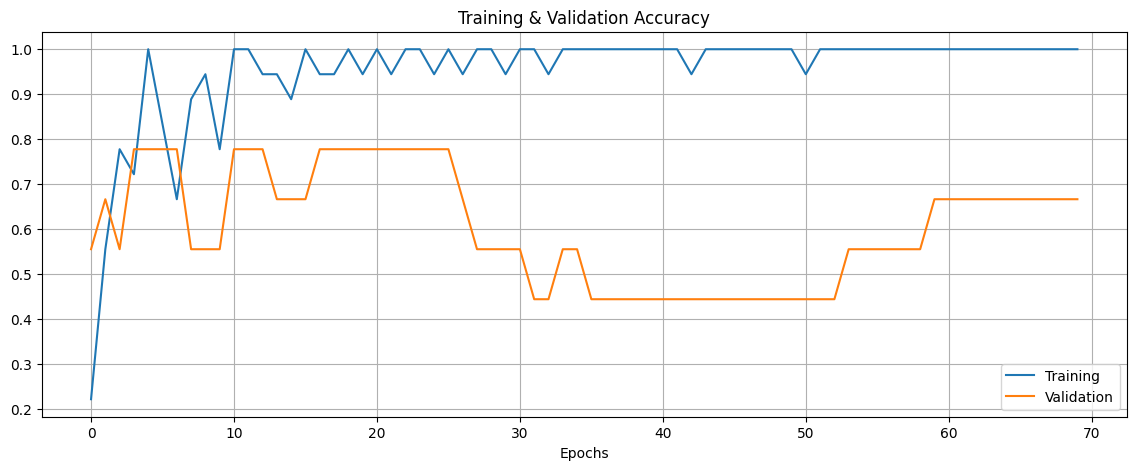

In [569]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))

axs.plot(range(len(history.history["val_sparse_categorical_accuracy"])), history.history["sparse_categorical_accuracy"], label="Training")
axs.plot(range(len(history.history["val_sparse_categorical_accuracy"])), history.history["val_sparse_categorical_accuracy"], label="Validation")
axs.set_xlabel("Epochs")
axs.set_title("Training & Validation Accuracy")
axs.legend()
axs.grid(True)


plt.show()

1/1 [==============================] - 2s 2s/step


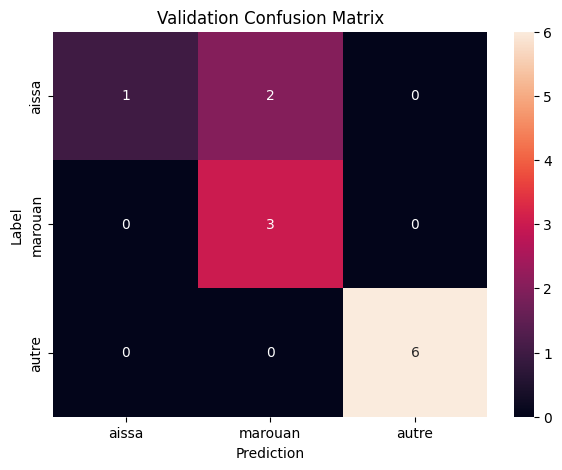

In [570]:
# Generate predictions
y_pred = model.predict(X_test)

# Calculate confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    y_test, np.argmax(y_pred, axis=1)
)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(
    confusion_mtx, xticklabels=["aissa", "marouan", "autre"], yticklabels=["aissa", "marouan", "autre"], annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Validation Confusion Matrix")
plt.show()

In [525]:
y_test

array([0, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2])

## Deep learning

In [323]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
import pandas as pd

Prepare the dataframe with the audio files and the labels.

In [324]:
aissa_files = os.listdir("Aissa")
aissa_files = ["Aissa/" + file for file in aissa_files]
marouan_files = os.listdir("Marouan")
marouan_files = ["Marouan/" + file for file in marouan_files]
autre_files = os.listdir("Autre")
autre_files = ["Autre/" + file for file in autre_files]

files = [*aissa_files, *marouan_files, *autre_files]

labels = []

for file in aissa_files:
    labels.append("aissa")
    
for file in marouan_files:
    labels.append("marouan")
    
for file in autre_files:
    labels.append("autre")

tf_dataframe = pd.DataFrame(files, columns = ["filename"])
tf_dataframe["label"] = labels

# Shuffle the samples
tf_dataframe = tf_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

tf_dataframe["label"] = tf_dataframe["label"].map({"aissa":0, "marouan":1, "autre":2})

tf_dataframe

,filename,label
0,Autre/bruits6-garder.wav,2
1,Autre/audio-garder.wav,2
2,Aissa/aissa_pass1.wav,0
3,Marouan/marouan1.wav,1
4,Autre/common_voice_fr_6.wav,2
5,Autre/bruit999-garder.wav,2
6,Aissa/aissa_pass3.wav,0
7,Autre/common_voice_fr_7.wav,2
8,Autre/bruits4-garder.wav,2
9,Marouan/marouan3.wav,1


Prepare training and validation sets 

In [325]:
split = int(len(tf_dataframe) * (1 - 0.2))
train_df = tf_dataframe[:split]
valid_df = tf_dataframe[split:]

print(
    f"We have {train_df.shape[0]} training samples & {valid_df.shape[0]} validation ones"
)


We have 31 training samples & 8 validation ones


In [326]:
# Load the YAMNet model
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

class_names = ["aissa", "marouan", "autre"]

@tf.function
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)

    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model(audio_wav)

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names)))


def dataframe_to_dataset(dataframe, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["filename"], dataframe["label"])
    )
    print(dataset)

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds = dataframe_to_dataset(train_df)
valid_ds = dataframe_to_dataset(valid_df)

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [352]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [354]:
def build_and_compile_model():
    inputs = keras.layers.Input(shape=(1024), name="embedding")

    # x = keras.layers.Reshape((32,32,1))(inputs)
    # x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_1")(x)
    # x = keras.layers.MaxPooling2D((2, 2), name="max_pooling_1")(x)
    # x = keras.layers.Flatten(name='flatten')(x)
    
    # inputs = keras.layers.Input(shape=(128), name="inputs")
    # x = keras.layers.Reshape((128,1))(inputs)
    # x = keras.layers.Conv1D(32, 3, activation='relu', padding='same', name="conv_1")(x)
    # x = keras.layers.MaxPooling1D(2, name="max_pooling_1")(x)
    # x = keras.layers.Flatten(name='flatten')(x)

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="ouput")(
        x
    )

    model = keras.Model(inputs=inputs, outputs=outputs, name="speaker_recognition")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1.9644e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],  
    )

    return model

# def build_and_compile_model():
#     model = tf.keras.Sequential([
#     feature_extractor_layer,
#     tf.keras.layers.Dense(len(class_names))
#     ])
#     model.build(input_shape=(None,1024))
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=1.9644e-5),
#         loss=keras.losses.CategoricalCrossentropy(),
#         metrics=["accuracy", keras.metrics.AUC(name="auc")],  
#     )
#     return model



model = build_and_compile_model()
model.summary()

Model: "speaker_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 384)               98688     
                                                                 
 dropout_2 (Dropout)         (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 192)               73920     
                                                                 
 dropout_3 (Dropout)         (None, 192)       

In [233]:
model.layers[13].output_shape

(None, 3)

In [234]:
y_train

4540    autre
4890    autre
653     autre
5144    autre
3668    autre
        ...  
585     autre
42      autre
241     autre
860     aissa
2121    autre
Length: 8114, dtype: object

In [355]:
class_counts = tf.zeros(shape=(len(class_names),), dtype=tf.int32)

for x, y in iter(train_ds):
    class_counts = class_counts + tf.math.bincount(
        tf.cast(tf.math.argmax(y, axis=1), tf.int32), minlength=len(class_names)
    )

class_weight = {
    i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()
    for i in range(len(class_counts))
}

print(class_weight)

{0: 3.950413223140496, 1: 4.230088495575221, 2: 1.959016393442623}


In [356]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=10, restore_best_weights=True
)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "speaker_recognition" + ".h5", monitor="val_auc", save_best_only=True
)

tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)

callbacks = [model_checkpoint_cb, tensorboard_cb]

In [357]:
train_ds_2 = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_train), tf.data.Dataset.from_tensor_slices(y_train.map({"aissa":0, "marouan":1, "autre":2})))).cache().batch(32).prefetch(tf.data.AUTOTUNE)
valid_ds_2 = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_test), tf.data.Dataset.from_tensor_slices(y_test.map({"aissa":0, "marouan":1, "autre":2})))).cache().batch(32).prefetch(tf.data.AUTOTUNE)
train_ds_2

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [358]:
history = model.fit(
    train_ds,
    epochs=200,
    validation_data=valid_ds,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/200
8/8 - 4s - loss: 3.3168 - accuracy: 0.2427 - auc: 0.4249 - val_loss: 1.0912 - val_accuracy: 0.3304 - val_auc: 0.5138 - 4s/epoch - 446ms/step
Epoch 2/200
8/8 - 0s - loss: 3.2600 - accuracy: 0.3285 - auc: 0.4885 - val_loss: 1.0859 - val_accuracy: 0.3571 - val_auc: 0.5349 - 155ms/epoch - 19ms/step
Epoch 3/200
8/8 - 0s - loss: 3.2672 - accuracy: 0.3075 - auc: 0.4765 - val_loss: 1.0808 - val_accuracy: 0.3661 - val_auc: 0.5616 - 160ms/epoch - 20ms/step
Epoch 4/200
8/8 - 0s - loss: 3.2566 - accuracy: 0.3431 - auc: 0.5186 - val_loss: 1.0759 - val_accuracy: 0.3839 - val_auc: 0.5813 - 145ms/epoch - 18ms/step
Epoch 5/200
8/8 - 0s - loss: 3.2149 - accuracy: 0.3849 - auc: 0.5670 - val_loss: 1.0711 - val_accuracy: 0.4018 - val_auc: 0.6060 - 151ms/epoch - 19ms/step
Epoch 6/200
8/8 - 0s - loss: 3.1997 - accuracy: 0.4163 - auc: 0.5928 - val_loss: 1.0663 - val_accuracy: 0.4107 - val_auc: 0.6291 - 154ms/epoch - 19ms/step
Epoch 7/200
8/8 - 0s - loss: 3.2010 - accuracy: 0.4142 - auc: 0.5852 - v

In [359]:
len(history.history["val_accuracy"])

200

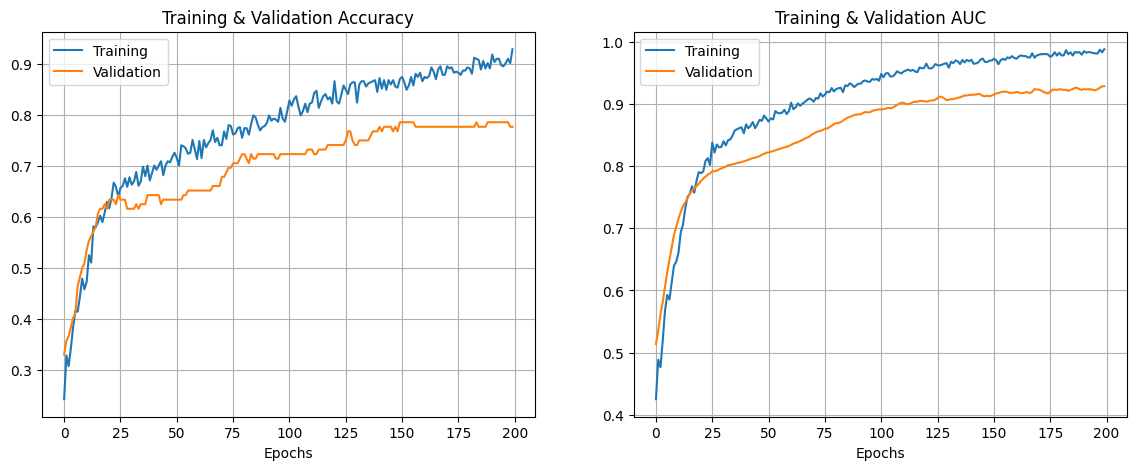

In [360]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(len(history.history["val_accuracy"])), history.history["accuracy"], label="Training")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(len(history.history["val_accuracy"])), history.history["auc"], label="Training")
axs[1].plot(range(len(history.history["val_accuracy"])), history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()

In [361]:
train_loss, train_acc, train_auc = model.evaluate(train_ds)
valid_loss, valid_acc, valid_auc = model.evaluate(valid_ds)

2/2 [==============================] - 0s 28ms/step - loss: 0.5286 - accuracy: 0.7768 - auc: 0.9287


4/4 [==============================] - 0s 6ms/step


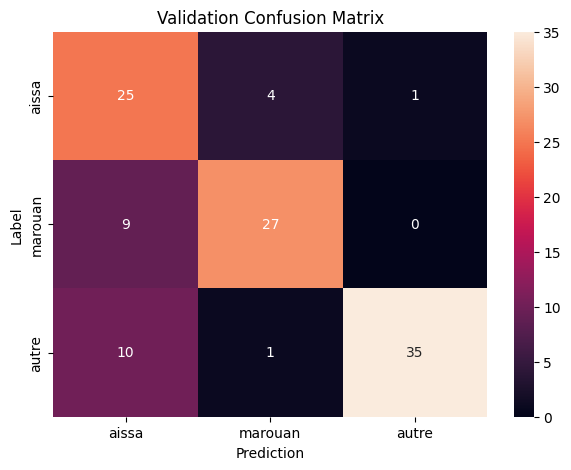

In [368]:
# Create x and y tensors
x_valid = None
y_valid = None

for x, y in iter(valid_ds):
    if x_valid is None:
        x_valid = x.numpy()
        y_valid = y.numpy()
    else:
        x_valid = np.concatenate((x_valid, x.numpy()), axis=0)
        y_valid = np.concatenate((y_valid, y.numpy()), axis=0)

# Generate predictions
y_pred = model.predict(x_valid)

# Calculate confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1)
)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(
    confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Validation Confusion Matrix")
plt.show()

In [367]:
print(classification_report(np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.57      0.83      0.68        30
           1       0.84      0.75      0.79        36
           2       0.97      0.76      0.85        46

    accuracy                           0.78       112
   macro avg       0.79      0.78      0.77       112
weighted avg       0.82      0.78      0.79       112



## Evaluation nouvel audio

In [445]:
samplerate = 48000  
duration = 5 # seconds
filename = 'eval.wav'

print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)
#reading the voice commands
samples, sample_rate = librosa.load(filename , sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

start
end


/tmp/ipykernel_5933/217246239.py:13: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  samples = librosa.resample(samples, sample_rate, 8000)


In [446]:
audio, _ = librosa.load("eval.wav")

# generate the "nutcracker" input data (ignore label series)
X_eval = generate_dataset(audio, 22050)

# predict the label for each spectrogram frame of "nutcracker"
y_pred_eval = pipe.predict(X_eval)

# compute count of unique values for each label
eval_unique_labels, eval_unique_counts = np.unique(y_pred_eval, return_counts=True)
eval_unique_labels, eval_unique_counts

/tmp/ipykernel_5933/592335859.py:4: FutureWarning: Pass y=[0.71068704 1.0871171  0.9489049  ... 0.3306287  0.32061717 0.3392941 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)


(array(['aissa', 'autre', 'marouan'], dtype=object), array([  5,  88, 123]))

In [447]:
 # find the majority class of "nutcracker"
eval_unique_labels[np.argmax(eval_unique_counts)]

'marouan'

In [450]:
y_autre

0       autre
1       autre
2       autre
3       autre
4       autre
        ...  
3659    autre
3660    autre
3661    autre
3662    autre
3663    autre
Length: 3664, dtype: object

In [ ]:
mod = load("rf_model.joblib")

# Deeplearning without transfer learning

In [318]:
# Percentage of samples to use for validation
VALID_SPLIT = 0.3

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 100

In [319]:
@tf.function
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)

    return audio_wav

# Split noise into chunks of 16000 each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    sample = tf.squeeze(sample, axis=-1)
    sampling_rate = tf.cast(sampling_rate, dtype=tf.int64)

    # Resample to 16k
    sample = tfio.audio.resample(sample, rate_in=sampling_rate, rate_out=16000)
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in autre_files:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(autre_files), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

Sampling rate for Autre/autre1.wav is incorrect. Ignoring it
Sampling rate for Autre/autre3.wav is incorrect. Ignoring it
Sampling rate for Autre/bruits4-garder.wav is incorrect. Ignoring it
Sampling rate for Autre/bruit999-garder.wav is incorrect. Ignoring it
Sampling rate for Autre/bruits6-garder.wav is incorrect. Ignoring it
Sampling rate for Autre/autre4.wav is incorrect. Ignoring it
Sampling rate for Autre/bruits5-garder.wav is incorrect. Ignoring it
Sampling rate for Autre/audio-garder.wav is incorrect. Ignoring it
Sampling rate for Autre/autre2.wav is incorrect. Ignoring it
19 noise files were split into 42 noise samples where each is 1 sec. long


In [320]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = ["aissa", "marouan", "autre"]

print("Our class names: {}".format(class_names,))

audio_paths = [*aissa_audios_paths, *marouan_audios_paths, *autre_audios_paths]
labels = [["aissa"]*10, ["marouan"]*10, ["autre"]*10]
labels = [item for sublist in labels for item in sublist]

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)
labels = pd.Series(labels).map({"aissa":0, "marouan":1, "autre":2})

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
# train_ds = train_ds.map(
#     lambda x, y: (add_noise(x, noises, scale=SCALE), y),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['aissa', 'marouan', 'autre']
Using 28 files for training.
Using 11 files for validation.


In [321]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)
tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_109 (Conv1D)            (None, 8000, 16)     64          ['input[0][0]']                  
                                                                                                  
 activation_78 (Activation)     (None, 8000, 16)     0           ['conv1d_109[0][0]']             
                                                                                                  
 conv1d_110 (Conv1D)            (None, 8000, 16)     784         ['activation_78[0][0]']          
                                                                                            

In [322]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[tensorboard_cb, mdlcheckpoint_cb],
)

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 2.3091 - accuracy: 0.3158 - val_loss: 0.9863 - val_accuracy: 0.2727
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 3.3235 - accuracy: 0.4211 - val_loss: 1.3138 - val_accuracy: 0.3636
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 1.7287 - accuracy: 0.5263 - val_loss: 2.3230 - val_accuracy: 0.2727
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 1.3850 - accuracy: 0.4737 - val_loss: 2.0638 - val_accuracy: 0.2727
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.2843 - accuracy: 0.5789 - val_loss: 1.3134 - val_accuracy: 0.4545
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 1.0233 - accuracy: 0.5789 - val_loss: 1.3127 - val_accuracy: 0.3636
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.0047 - accuracy: 0.5789 - val_loss: 1.4559 - val_accuracy: 0.3636
Epoch 8/100
1/1 [=================

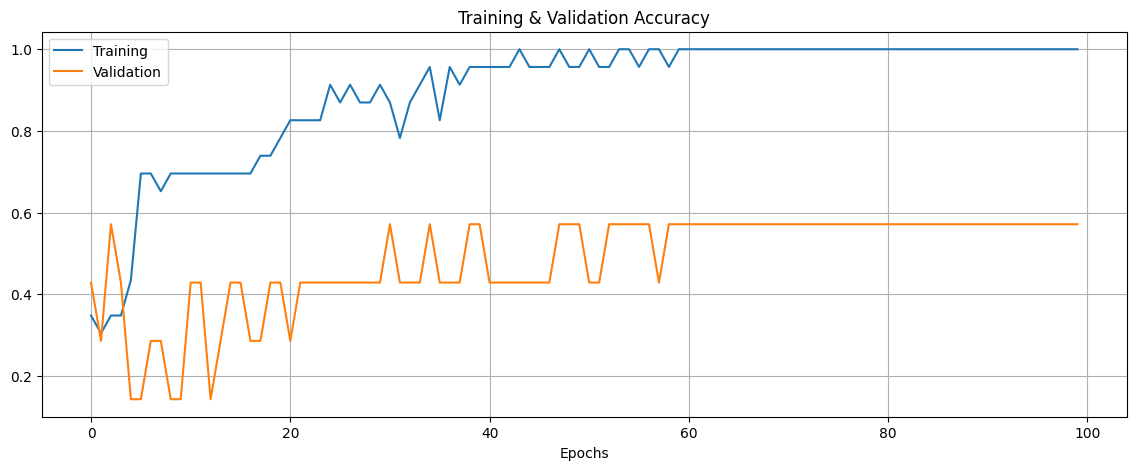

In [309]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))

axs.plot(range(len(history.history["val_accuracy"])), history.history["accuracy"], label="Training")
axs.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
axs.set_xlabel("Epochs")
axs.set_title("Training & Validation Accuracy")
axs.legend()
axs.grid(True)

plt.show()

In [311]:
# Create x and y tensors
x_valid = None
y_valid = None

for x, y in iter(valid_ds):
    if x_valid is None:
        x_valid = x.numpy()
        y_valid = y.numpy()
    else:
        x_valid = np.concatenate((x_valid, x.numpy()), axis=0)
        y_valid = np.concatenate((y_valid, y.numpy()), axis=0)

# Generate predictions
y_pred = model.predict(x_valid)

# Calculate confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.argmax(y_valid), np.argmax(y_pred)
)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Validation Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 192ms/step


ValueError: Argument `axis` = 1 not in range [-1, 1)

# STT


In [8]:
import speech_recognition as sr
# Initialize recognizer class                                       
r = sr.Recognizer()
# audio object                                                         
audio = sr.AudioFile("Aissa/aissa_pass2.wav")
#read audio object and transcribe
with audio as source:
    audio = r.record(source)                  
    result = r.recognize_google(audio, language="fr-FR")
    
print(result)

result2:
{   'alternative': [   {   'confidence': 0.90022755,
                           'transcript': 'sésame ouvre-toi'},
                       {'transcript': "c'est Sam ouvre-toi"},
                       {'transcript': "c'est Sam ouvre toi"}],
    'final': True}
sésame ouvre-toi


In [7]:
result == "sésame ouvre-toi"

True

In [56]:
from difflib import SequenceMatcher


SequenceMatcher(None, 'c est Sam ouvre toi','sésame ouvre-toi', ).ratio()

0.6857142857142857